# Aнализ игр компании "Стримчик"

<b>Цель проекта:</b> анализ игр с целью выведения наилучшей стратегии по продажам и рекламе на будущий год.

<b>Доступны следующие данные:</b>
- исторические данные о продажах игр,
- оценки пользователей и экспертов, 
- жанры и платформы (например, Xbox или PlayStation). 

<b>Обозначения:</b>
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

<b>Задача: </b>
- выявить определяющие успешность игры закономерности. 


## Загрузка и подготовка данных

### Импорт необходимых библиотек и модулей

In [63]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats as st
from pymystem3 import Mystem 

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

### Первичный взгляд на данные

In [64]:
data = pd.read_csv('/datasets/games.csv')
display(data.shape)
display(data.dtypes)
display(data.sample(3))

(16715, 11)

Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
12488,Hisshou Pachinko*Pachi-Slot Kouryaku Series Po...,PSP,2010.0,Misc,0.0,0.00,0.06,0.00,NaN,NaN,NaN
3319,Naruto: Ultimate Ninja,PS2,2003.0,Fighting,0.5,0.02,0.00,0.08,75.0,7.7,T
3328,Aliens: Colonial Marines,PS3,2013.0,Shooter,0.2,0.29,0.00,0.11,43.0,3.6,M


<b>ВЫВОД:</b> датасет насчитывает 16715 наблюдений и 11 признаков. Типы данных представлены числами с плавающей точкой и строками.

### Поиск пропусков и дубликатов

Количество дубликатов в датасете: 0


,0
Critic_Score,8578
Rating,6766
User_Score,6701
Year_of_Release,269
Name,2
Genre,2
Platform,0
NA_sales,0
EU_sales,0
JP_sales,0


Text(0.5, 1.0, 'Количество пропущенных значений в столбцах датасета')

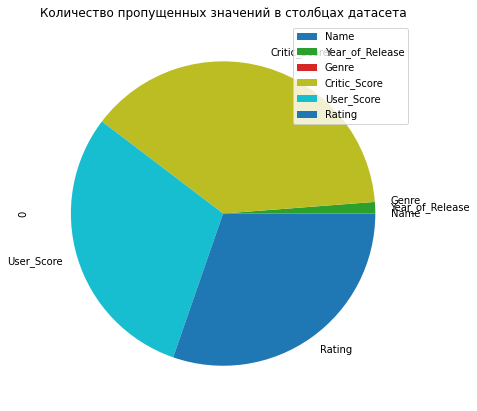

In [65]:
# выведем число дубликатов
print('Количество дубликатов в датасете:', data.duplicated().sum())

# выведем количество пропущенных значений
display(pd.DataFrame(data.isna().sum().sort_values(ascending = False)))

# добавим визуализацию
pd.DataFrame(data.isna().sum()).plot(kind = 'pie', subplots = True, figsize = (7,7))
plt.title('Количество пропущенных значений в столбцах датасета')

<b>ВЫВОД:</b> дубликатов нет, пропуски в 6 столбцах, много пропусков в рейтинге игр и оценках пользователей и критиков. Неинформативные наблюдения (с пропуском в названии игры и жанра) можно удалить, их всего 2.

## Предобработка данных

### Унификация названий столбцов и удаление малоинформативных наблюдений

In [66]:
# поправим названия столбцов
new_columns = []
for column in data.columns:
    column = column.lower()
    new_columns.append(column)
data.columns = new_columns

# проверим изменения
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [67]:
# удалим малоинформативные наблюдения
data.dropna(subset = ['name', 'genre'], axis = 0, inplace = True)
data.dropna(subset = ['year_of_release'], axis = 0, inplace = True)

# проверим изменения
data.shape

(16444, 11)

### Обработка пропусков
- пропуски остались в трех столбцах - оценках критиков и пользователей и рейтинге игры. Рейтинг игры заполним согласно моде, сгруппировав таблицу по жанрам. Оценки можно попробовать восстановить, изучив их корреляцию.

#### Заполнение пропусков в значениях рейтинга игры

In [68]:
# аггрегируем таблицу по жанрам и выведем моду рейтинга 
grouped_genres = data.groupby('genre')['rating'].agg(pd.Series.mode)

# заполним пропуски в рейтинге
def func(row):
    if pd.isna(row['rating']):
        return grouped_genres.loc[row['genre']]
    return row['rating']
 
data['rating'] = data.apply(func, axis=1)

# проверим данные
print('Пропусков в рейтинге после преобразований:', data['rating'].isna().sum())
data.sample(3)

Пропусков в рейтинге после преобразований: 0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
12920,Adventure Time: Finn & Jake Investigations,XOne,2015.0,Action,0.03,0.02,0.0,0.0,NaN,NaN,T
12059,RayStorm,PS,1997.0,Shooter,0.04,0.03,0.0,0.0,79.0,7.8,E
12205,Card Games,PS,2000.0,Misc,0.04,0.03,0.0,0.0,NaN,NaN,E


#### Заполнение пропусков в значениях оценок критиков и пользователей

In [69]:
# заменим значение tbd в user_score
data['user_score'] = data['user_score'].replace('tbd', np.nan).astype('float')

# проверим, сколько стало пропусков с учетом tbd
print('Пропусков в оценках пользователей:', data['user_score'].isna().sum())

# оценим корреляцию оценок пользователей 
pd.DataFrame(data.corr()['critic_score'].sort_values(ascending = False))

Пропусков в оценках пользователей: 8981


,critic_score
critic_score,1.000000
user_score,0.579671
na_sales,0.240083
eu_sales,0.221276
other_sales,0.198410
jp_sales,0.153474
year_of_release,0.011411


<b>ПРОМЕЖУТОЧНЫЙ ВЫВОД:</b>  прослеживается четкая положительная корреляция между оценками пользователей и критиков. На основании этого произведем заполнение значений.

<i>Логика следующая: мы можем заполнить оценки только при наличии оценки другой категории. В противном случае данных недостаточно, чтобы с уверенностью сказать, что пропуски можно заполнить медианным значением по жанрам. Например, могла выйти совершенно отвратительная игра с низкой оценкой. Плюс мы ничего не можем сделать с tbd при наличии пропусков в оценках критиков.</i>

In [70]:
# аггрегируем данные по жанрам и медианные оценкам
genre_scores = data.groupby('genre').agg({'user_score':'mean', 'critic_score':'mean'})

# добавим столбец отношения оценки польз. к оценке критиков
genre_scores['relation'] = genre_scores['user_score'] / genre_scores['critic_score']

# проверим данные
display(genre_scores.sample(3))

,user_score,critic_score,relation
genre,,,
Action,7.058129,66.676931,0.105856
Racing,7.040859,68.006897,0.103532
Adventure,7.139597,65.268750,0.109388


In [71]:
# создадим ф-цию для добавления вспомогтельной фичи
def add_rel(row):
    return genre_scores.loc[row['genre']]['relation']
    
data['score_relation'] = data.apply(add_rel, axis=1)

# проверим данные с новой фичой
display(data.sample(3))

# произведем заполнение пропусков
data['user_score'] = data['user_score'].fillna(data['critic_score'] * data['score_relation'])

# проверим данные
display(data.sample(3))
print('Пропусков в оценках пользователей после преобразований:', data['user_score'].isna().sum())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,score_relation
9679,Strikers 1945,PS,1998.0,Shooter,0.07,0.05,0.00,0.01,63.0,8.2,E,0.100388
2113,NCAA Football 06,XB,2005.0,Sports,0.73,0.21,0.00,0.03,87.0,8.3,E,0.096557
365,Tomb Raider III: Adventures of Lara Croft,PS,1997.0,Action,1.66,1.58,0.12,0.18,NaN,NaN,T,0.105856


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,score_relation
419,Tekken,PS,1995.0,Fighting,0.95,1.3,0.77,0.22,NaN,NaN,T,0.105501
10358,MLB 14: The Show,PSV,2014.0,Sports,0.08,0.0,0.00,0.03,68.0,7.0,E,0.096557
15702,James Bond 007: Blood Stone,PC,2010.0,Shooter,0.02,0.0,0.00,0.00,63.0,7.1,T,0.100388


Пропусков в оценках пользователей после преобразований: 7892


In [72]:
# аналогично заполним пропуски в оценках критиков
data['critic_score'] = data['critic_score'].fillna(data['user_score'] // data['score_relation'])

# проверим данные
display(data.sample(3))
print('Пропусков в оценках критиков после преобразований:', data['critic_score'].isna().sum())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,score_relation
10593,You Don't Know Jack: Mock 2,PS,2000.0,Misc,0.06,0.04,0.00,0.01,82.0,8.373471,E,0.102115
14886,Cake Mania: Baker's Challenge,PS2,2008.0,Puzzle,0.01,0.01,0.00,0.00,NaN,NaN,E,0.106176
776,Final Fantasy Tactics Advance,GBA,2003.0,Role-Playing,0.82,0.37,0.89,0.05,87.0,7.800000,E,0.104940


Пропусков в оценках критиков после преобразований: 7892


<b> ВЫВОД:</b> все остальные наблюдения имеют пропуски в оценках обоих типов. Вспомогательный столбец можно удалить за ненадобностью и перейти к изменению типов данных.

In [73]:
# удалим вспомогательный столбец
data.drop('score_relation', axis = 1, inplace = True)

# проверим данные
data.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7733,Danganronpa 2: Goodbye Despair,PSP,2012.0,Misc,0.00,0.00,0.19,0.00,NaN,NaN,E
4084,Jeopardy!,PS2,2003.0,Misc,0.24,0.18,0.00,0.06,NaN,NaN,E
12790,The Lord of the Rings: Aragorn's Quest,PS2,2010.0,Action,0.03,0.02,0.00,0.01,NaN,NaN,E10+


### Изменение типов данных

In [74]:
# сделаем целочисленный год
data['year_of_release'] = data['year_of_release'].astype('Int64')

# изменим оценки критиков
data['critic_score'] = data['critic_score'].astype('Int64')

# проверим изменения
data.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         Int64
user_score         float64
rating              object
dtype: object

### Подсчет суммарных продаж

In [75]:
data['total_sales'] =  data['eu_sales'] + data['jp_sales'] + data['na_sales'] + data['other_sales']  

# проверим данные
data.sample(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
13604,Corpse Party: Book of Shadows,PSP,2011,Adventure,0.00,0.00,0.04,0.00,67,8.2,M,0.04
6377,Ultimate NES Remix,3DS,2014,Action,0.15,0.09,0.00,0.02,69,7.6,E,0.26
15290,Geon Cube,Wii,2009,Puzzle,0.02,0.00,0.00,0.00,<NA>,NaN,E,0.02


### Вывод:
- данные загружены и изучены
- данные предобработаны (заполнены пропуски, изменены типы, удалены ненужные значения)
- добавлен столбец с продажами 

Можно переходить к исследовательскому анализу.

## Исследовательский анализ данных 

<b>Стадия I. Анализ для выявления актуального периода</b>
- определить, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- определить, как менялись продажи по платформам. 
- выбрать платформы с наибольшими суммарными продажами и построить распределение по годам. 
- определить характерный срок, за который появляются новые и исчезают старые платформы
- определить актуальный период, данные за который помогут построить прогноз на 2017 год.

<b>Стадия II. Анализ данных по актуальному периоду</b>
- определить, какие платформы лидируют по продажам, какие растут и какие или падают. Выбрать несколько потенциально прибыльных платформ.
- построить «ящик с усами» по глобальным продажам игр в разбивке по платформам. Описать результат.
- определить, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
- построить диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сделать выводы.
- соотнести выводы с продажами игр на других платформах.
- посмотреть на общее распределение игр по жанрам. Описать самые прибыльные жанры. Определить, выделяются ли жанры с высокими и низкими продажами.

### Установление актуального периода

#### Изучение количества выпущенных игр в разные годы

Text(0.5, 1.0, 'Динамика выпуска игр по годам')

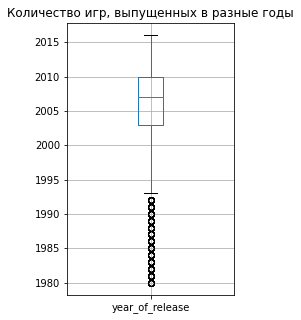

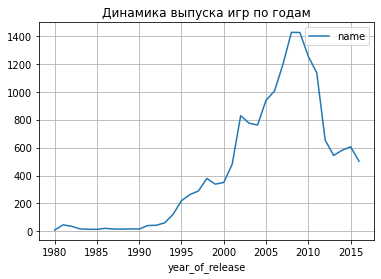

In [76]:
# визуализируем кол-во игр по годам
data.boxplot(column = 'year_of_release', figsize = (3,5))
plt.title('Количество игр, выпущенных в разные годы')

# посмотрим на кол-во игр в динамике
data.groupby('year_of_release').agg({'name':'count'}).plot(grid = True, sharex = True)
plt.title('Динамика выпуска игр по годам')

<b>ВЫВОДЫ:</b>
- выбросы ниже 1993 года
- медиана - 2007 год
- граница верхней нормы - 2016 год
- диапазон Q2-Q3: 2003-2010 год

Период "роста" с 1993 по 2007 с небольшими периодами упадка в 1997-1998, 2002-2004. После 2007-2008 года, когда наблюдалось плато, пошел период спада, довольно резкий и продлившийся до 2013 года. 2013-2014 год - небольшой рост, далее график уходит вниз, это мб обусловлено отсутствием всех необходимых данных за 2016 год.

<b>Гипотеза:</b> судя по динамике, после пика в 2007-2008 производство стабильно идет на спад. Поэтому, вероятно, целесообразно учитывать данные после "пикового" периода. Гипотезу нужно будет подтвердить другими данными, например, "сроком жизни" платформ.
Игры старше 1993 года можно не учитывать при анализе. 

In [77]:
# удалим игры старше 1993 года
data = data.query('year_of_release > 1993')
print('Игр выпуска 1993 года и позже:', len(data))

Игр выпуска 1993 года и позже: 16079


#### Определение динамики продаж по разным платформам

,,total_sales
year_of_release,platform,
2004,PS2,211.81
2009,Wii,206.97
2002,PS2,205.38
2003,PS2,184.31
2008,Wii,171.32
2010,X360,170.03
1998,PS,169.49
2001,PS2,166.43
2005,PS2,160.66


<AxesSubplot:xlabel='year_of_release,platform'>

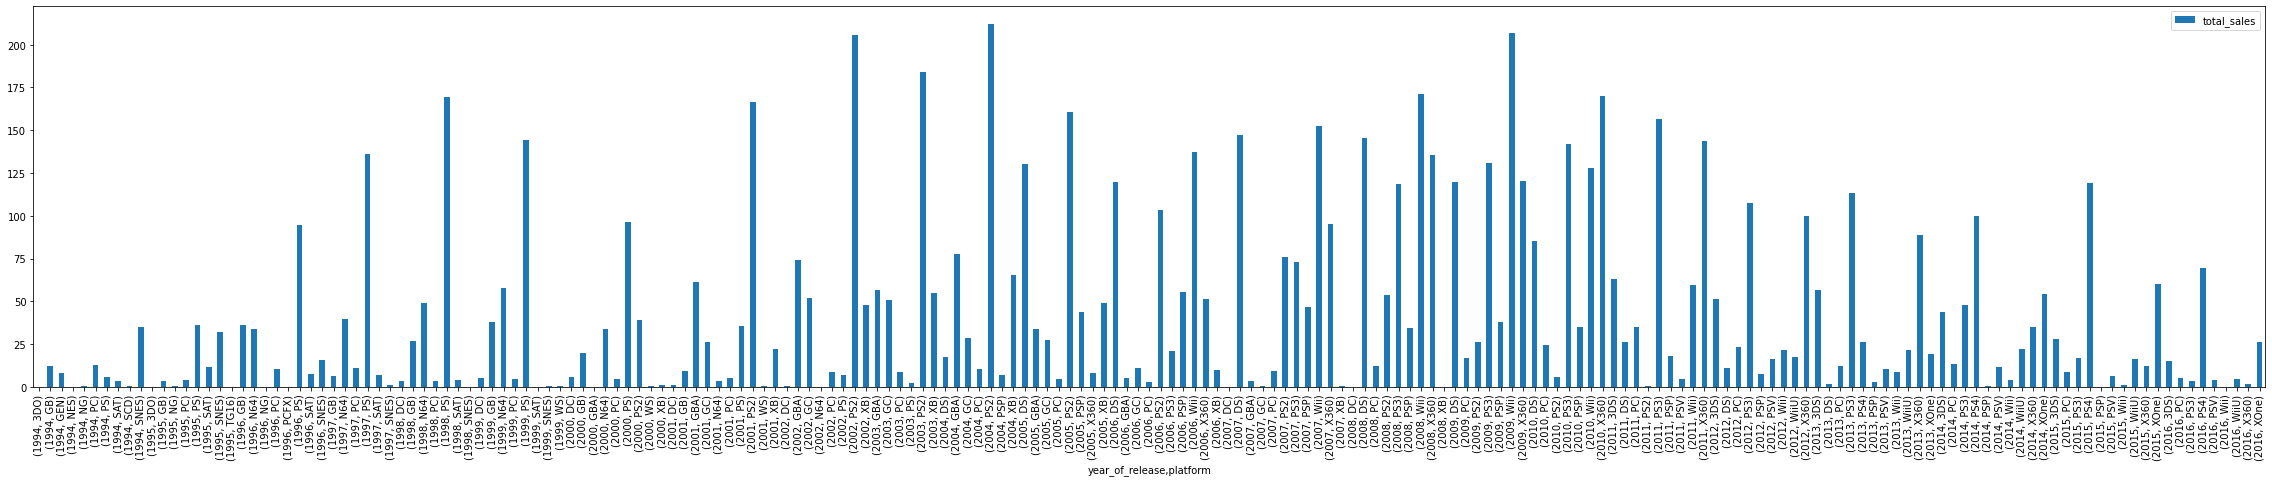

In [78]:
# аггрегируем сведения по годам и платформам 
display(data.groupby(['year_of_release', 'platform']).agg({'total_sales' : 'sum'}).sort_values(by = 'total_sales',
                                                                                               ascending = False).head(10))
# добавим визуализацию
data.groupby(['year_of_release', 'platform']).agg({'total_sales' : 'sum'}).plot(kind = 'bar', figsize = (40,7))

<b>ВЫВОД:</b> для почти всех платформ характерно нормальное распределение продаж, самые высокие продажи в середине периода существования платформы, с возрастающими значениями до середины и снижением к концу "жизни" платформы.

#### Выявление самых высокопродаваемых платформ 

<AxesSubplot:xlabel='platform'>

Text(0.5, 1.0, 'Топ-10 высокопродаваемых платформ')

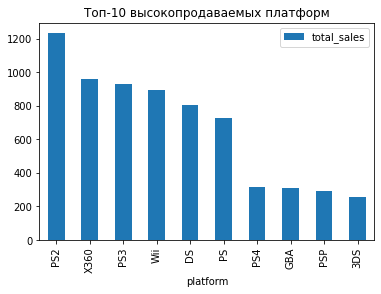

In [79]:
# аггрегируем сведения по платформам без учета года 
display(data.groupby(['platform']).agg({'total_sales' : 'sum'}).sort_values(by = 'total_sales',
                                                                                               ascending = False).head(10).plot(kind = 'bar'))
plt.title('Топ-10 высокопродаваемых платформ')

<b>ВЫВОД:</b> со значительным отрывом выявлено шесть лидеров:
- PS2
- X360
- PS3
- Wii
- DS
- PS

Text(0.5, 1.0, 'Динамика продаж топовых платформ по годам')

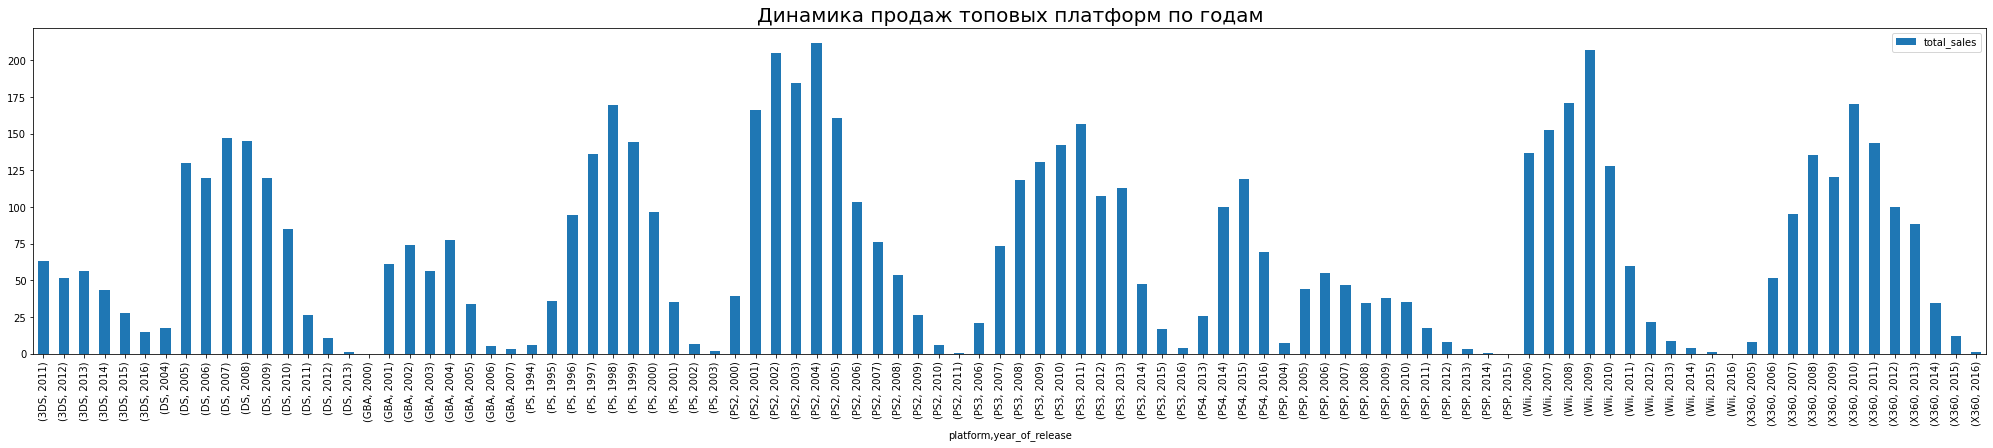

In [80]:
# отберем топовые платформы
tops =  ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']
top_platforms = data.query('platform in @tops')

# сгруппируем по годам и визуализируем
top_platforms.groupby(['platform', 'year_of_release']).agg({'total_sales' :'sum'}).plot(kind = 'bar',
                                                                                        figsize = (35,6))
plt.title('Динамика продаж топовых платформ по годам', fontsize = 20)

<b>ВЫВОДЫ:</b>
- для всех платформ характерно нормальное распределение продаж
- спад продаж наблюдается, когда на смену платформе приходит другая, более популярная
- как правило, после появления новой платформы, старая уходит с рынка
- на момент 2016 года игры выпустили 4 высокопродаваемых платформы.

#### Определение срока жизни платформ

Средний срок жизни платформы состаляет: 8.6 лет


Text(0.5, 1.0, 'Срок жизни платформ')

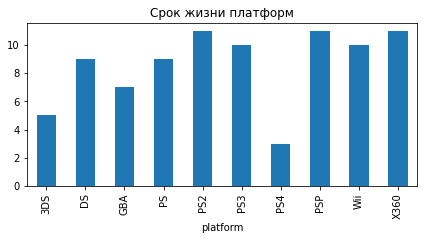

In [81]:
# определим средний срок жизни платформы
life_period = top_platforms.groupby('platform').agg({'year_of_release':'max'})
life_period['min'] = top_platforms.groupby('platform').agg({'year_of_release':'min'}).astype('int64')
life_period['period'] = life_period['year_of_release'] - life_period['min']
print('Средний срок жизни платформы состаляет:', life_period['period'].mean(), 'лет')

# добавим визуализацию
life_period['period'].plot(kind = 'bar', figsize = (7,3))
plt.title('Срок жизни платформ')

<b>ВЫВОД:</b> средний срок жизни платформы - 8,6 лет. 

#### Определение актуального периода для прогноза продаж на 2017 
<b>Логика действий:</b>
- установлено, что средний срок жизни платформы - 8.6 лет
- срок жизни может быть и больше (т.к. показатели снижают "молодые" платформы), но, в любом случае, платформа должна выпустить хотя бы одну игру на период 2016 года

In [82]:
# выявим актуальные платформы
modern_platforms = list(life_period[life_period['year_of_release'] > 2015].index)
# проверим данные
modern_platforms

['3DS', 'PS3', 'PS4', 'Wii', 'X360']

<b>ВЫВОД:</b> выделены пять актуальных платформ. Будем рассматривать данные по ним за последние 9 лет.

### Анализ данных по актуальному периоду

#### Определение платформ-лидеров по продажах. Определение платформ с растущими и убывающими продажами

In [83]:
relevant_period = data.query('year_of_release > 2007')
#relevant_period = relevant_period.query('platform in @modern_platforms')
print('Наблюдений за актуальный период:', len(relevant_period))

Наблюдений за актуальный период: 8130


Text(0.5, 1.0, 'Динамика продаж топовых платформ за актуальный период')

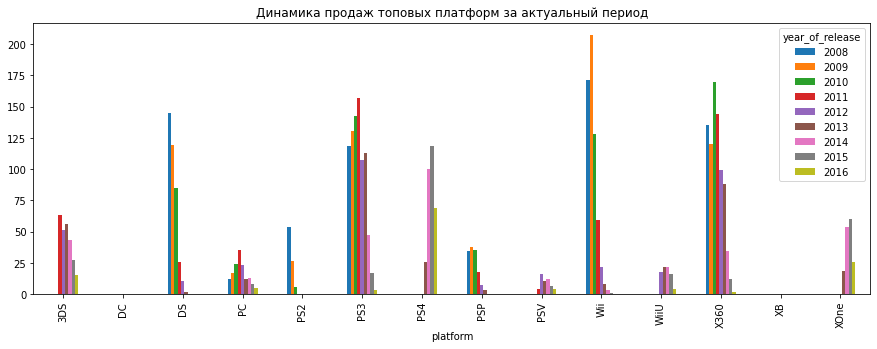

In [84]:
relevant_pivot = relevant_period.pivot_table(index = 'platform', columns = 'year_of_release',
                       values = 'total_sales', aggfunc = 'sum')
relevant_pivot.plot(kind = 'bar', figsize = (15,5))
plt.title('Динамика продаж топовых платформ за актуальный период')

<b>ВЫВОД:</b> 
<u>Лидеры продаж:</u> '3DS', 'PS3', 'PS4', 'Wii', 'X360'

<u>Растущие продажи:</u> PS4, Xone.

<u>Спад продаж:</u> 3DS, PS3, Wii, X360 и все остальные

<b>Гипотеза:</b> потенциально прибыльная платформа PS4. Явные "антиплатформы" с самыми резкими спадами - PS3 (т.к. есть более новая модель той же линейки), Wii (по той же причине), X360. 

#### Изучение глобальных продаж по платформам

<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

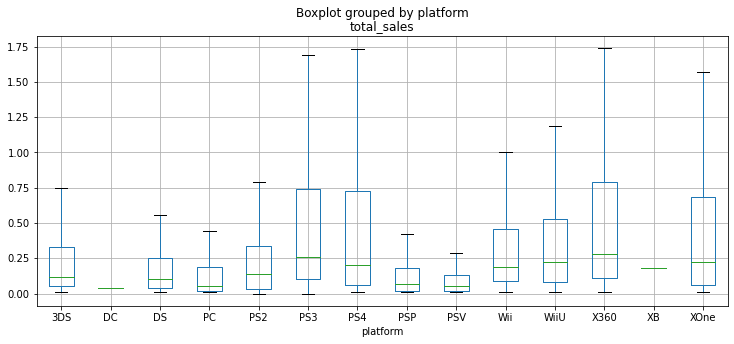

In [85]:
relevant_period.boxplot(column = 'total_sales', by = 'platform', 
                        figsize = (12,5), showfliers = False)

<b>ВЫВОД:</b> свыше 2 млн начинаются выбросы. При этом размах нормальных значений для каждой из платформ составляет:
- 3DS в пределах 0.75 млн
- PC в пределах 0.4
- PS3 в пределах 1.7 млн
- PS4 в пределах 1.75 млн
- PSV в пределах 0.27 млн
- Wii в пределах 1 млн
- WiiU в пределах 1.2 млн
- X360 в пределах 1.75 млн
- XOne в пределах 1.6 млн

#### Изучение влияния отзывов пользователей и критиков на продажи  внутри одной популярной платформы
*для анализа возьмем PS4, так как она в топе с растущими продажами и относительно "молодая"*

,total_sales
year_of_release,-0.235032
na_sales,0.928160
eu_sales,0.958157
jp_sales,0.527129
other_sales,0.998051
critic_score,0.404833
user_score,-0.033020
total_sales,1.000000


Text(0.5, 1.0, 'Корреляция продаж и отзывов пользователей для PS4')

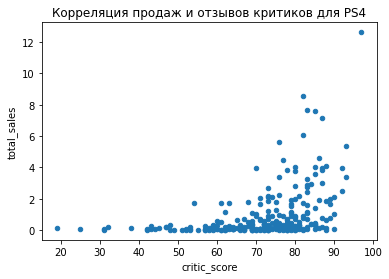

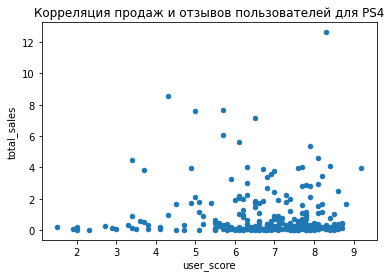

In [86]:
# возьмем срез данных
ps4_data = relevant_period[relevant_period['platform'] =='PS4']

# оценим корреляцию отзывов и продаж
display(pd.DataFrame(ps4_data.corr()['total_sales']))

# добавим визуализацию
ps4_data.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Корреляция продаж и отзывов критиков для PS4')
ps4_data.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Корреляция продаж и отзывов пользователей для PS4')

<b>ВЫВОД:</b> корреляция продаж с отзывами критиков составляет 0.4, она слабо-умеренная. Корреляция продаж с отзывами пользователей -0.03, она почти отсутствует.

#### Изучение корреляции продаж и отзывов на других платформах.

,total_sales
year_of_release,-0.024248
na_sales,0.947169
eu_sales,0.935212
jp_sales,0.546961
other_sales,0.880170
critic_score,0.262554
user_score,0.103048
total_sales,1.000000


Text(0.5, 1.0, 'Корреляция продаж и отзывов критиков')

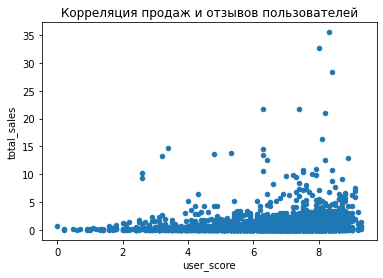

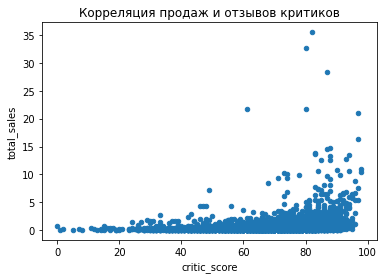

In [87]:
# возьмем срез данных
other_platforms = relevant_period[relevant_period['platform'] !='PS4']
display(pd.DataFrame(other_platforms.corr()['total_sales']))

# добавим визуализацию
other_platforms.plot(x = 'user_score', y = 'total_sales', kind = 'scatter')
plt.title('Корреляция продаж и отзывов пользователей')
other_platforms.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter')
plt.title('Корреляция продаж и отзывов критиков')

<b>ВЫВОД:</b> в рамках остальных платформ наблюдается та же самая тенденция, что и для XOne: слабая корреляция между продажами и отзывами критиков и практически полное ее отсутствие в случае отзывов пользователей.

#### Изучение распределения игр по жанрам. Выделение наиболее прибыльных жанров. Выявление жанров с высокими и низкими продажами

Text(0.5, 1.0, 'Распределение кол-ва выпущенных игр и их продаж по жанрам')

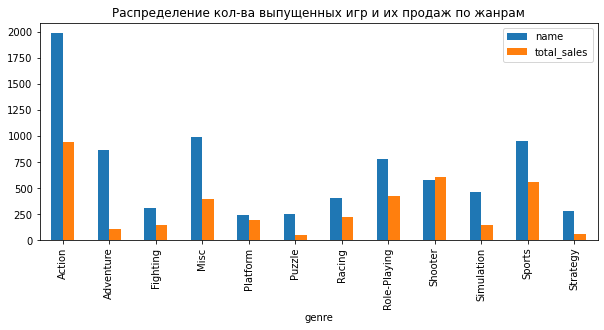

In [88]:
# аггрегируем данные и визуализируем их
relevant_period.pivot_table(index = 'genre', values = ['total_sales', 'name'],
                      aggfunc = {'total_sales':'sum', 'name':'count'}).plot(kind = 'bar', figsize = (10,4))
plt.title('Распределение кол-ва выпущенных игр и их продаж по жанрам')

<b>ВЫВОД:</b> топ-5 жанров по продажам:
- action
- shooter
- role playing
- sports
- misc

Жанры с самыми низкими продажами:
- puzzle
- strategy
- adventure
- simulation
- fighting

### Вывод:

- На основании данных определен актуальный период исследования: 2009-2016 год. Установлено, что средний срок жизни платформы составляет 8,6 лет.

- Лидеры продаж по платформам: 3DS, PS3, PS4, X360, XOne. При этом растущая тенденция продаж наблюдается только у двух платформ: PS4 и XOne. Платформы PC, PSV и WiiU характеризуются плавным падением продаж, резкий спад продаж наблюдается у платформ 3DS, PS3, Wii, X360. Возможная причина - появление более новой платформы в рамках одной линейки.

<b>Гипотеза</b> потенциально прибыльные для развития платформы PS4 и XOne (т.к. у них растущие продажи и они в топ-5 лидеров по продажам).

- Размах нормальных значений продаж для каждой из платформ составляет не более 0.5-1.75 млн копий. 

- для всех платформ наблюдается слабая корреляция между продажами и отзывами критиков и практически полное ее отсутствие в случае отзывов пользователей.

- топ-5 жанров по продажам: action, shooter, role playing, sports, misc.

- жанры с самыми низкими продажами: puzzle, strategy, adventure, simulation, fighting.

## Составление портрета пользователя каждого региона
<b>Задачи:</b>

Определить для пользователя каждого региона (NA, EU, JP):
- самые популярные платформы (топ-5). Описать различия в долях продаж.
- самые популярные жанры (топ-5). Пояснить разницу.
- влияет ли рейтинг ESRB на продажи в отдельном регионе.

### Определение топ-5 платформ по регионам. Описание различий в продажах

In [89]:
# аггрегируем продажи по регионам
values = ['eu_sales', 'na_sales', 'jp_sales']
for value in values:
    region_prefs = relevant_period.pivot_table(index = 'platform', values = value, aggfunc = 'sum').sort_values(by = value, ascending = False)
    display(region_prefs[0:5])

,eu_sales
platform,
PS3,293.73
X360,234.88
Wii,170.74
PS4,141.09
PC,92.17


,na_sales
platform,
X360,490.69
PS3,349.13
Wii,332.87
DS,198.73
PS4,108.74


,jp_sales
platform,
3DS,100.62
DS,76.12
PS3,74.11
PSP,60.46
Wii,47.01


<b>ВЫВОД:</b> топ-5 Европы и США схож по составу и распеределению мест. В обоих случаях в топ-5 входят PS3 и X360, занимающие 1 и 2 места (в Европе более популярна PS3, в США Xbox), тройку лидеров замыкает Wii в обоих случаях. PS4 занимает 4 место в Европе и 5 в США, уступая DS. Пятерку европейских лидеров замыкает PC.
Япония сильно отличается по составу и находится ближе к США, чем к Европе. Первое место - 3DS, второе - DS. Троку лидеров замыкает PS3. На 4 и 5 местах расположились PSP и Wii.

<u>Различия продаж:</u> общая картина такова, что продажи в Японии самые маленькие, более чем в 2.5 раза меньше, чем в Европе. Лидирует США, опережая Европу примерно в полтора раза.

### Определение топ-5 жанров по регионам 

In [90]:
for value in values:
    region_genre_prefs = relevant_period.pivot_table(index = 'genre', values = value, aggfunc = 'sum').sort_values(by = value, ascending = False)
    display(region_genre_prefs[0:5])

,eu_sales
genre,
Action,310.59
Shooter,208.35
Sports,185.19
Misc,107.00
Role-Playing,94.46


,na_sales
genre,
Action,433.74
Shooter,311.26
Sports,276.27
Misc,211.61
Role-Playing,155.81


,jp_sales
genre,
Role-Playing,138.12
Action,90.16
Misc,37.33
Sports,30.69
Adventure,23.36


<b>ВЫВОД:</b> топ-5 в Европе и США полностью совпадает: 1 место - экшн, на 2 - шутеры, на 3 - спортивные игры, на 4 - Misc, на 5 -RPG.
Японцы более всего предпочитают RPG, экшн и misc. Спортивные игры на 4 месте, на 5 жанр adventure.

### Установление влияния рейтинга ESRB на продажи в регионах

In [91]:
for value in values:
    region_rating_prefs = relevant_period.pivot_table(index = 'rating', values = value, aggfunc = 'sum').sort_values(by = value, ascending = False)
    display(region_rating_prefs)

,eu_sales
rating,
E,426.42
M,383.84
T,255.47
E10+,144.53
RP,0.03
EC,0.00


,na_sales
rating,
E,628.40
M,529.86
T,403.19
E10+,251.88
EC,1.32
RP,0.00


,jp_sales
rating,
T,208.62
E,151.76
M,41.23
E10+,25.67
EC,0.00
RP,0.00


<b>ВЫВОД:</b> рейтинг влияет на продажи. RP и EC нулевые во всех регионах, M, E и Т лидируют во всех регионах. В США и Европе картина совпадает: 1 место - Е, 2 место- М, 3 место - Т. В Японии E сдвигается на 2 место, а М на третье, 1 место занимает Т. Рейтинг Е10+ на 4 месте во всех трех регионах.

### Вывод:

<b>Общий потртет американского геймера:</b>
- предпочитает платформы: X360, PS3, Wii
- является самым активным потребителем рынка, примерно в полтора раза опережая европейца и в пять раз - японца
- предпочитает жанры action, шутеры и спортивные игры.
- покупает игры рейтинга M,E, T

<b>Общий потртет европейского геймера:</b>
- предпочитает платформы: PS3, Х360 и Wii
- играет примерно в 2.5 раза больше японца, но гораздно меньше, чем американец 
- предпочитает жанры action, шутеры и спортивные игры
- покупает игры рейтинга M,E, T

<b>Общий потртет японского геймера:</b>
- предпочитает платформы: 3DS, DS, PS3
- играет меньше всех
- предпочитает жанры RPG, action и misc
- покупает игры рейтинга E, T, M

<b>Заключение:</b> менталитет и вкусы европейцев и американцев совпадают. Японцы являются собой совершенно другую ЦА, к которой нужен отдельный подход.

## Проверка гипотез:

- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- средние пользовательские рейтинги жанров Action и Sports разные.

<i>пороговое значение alpha 0.05</i>

### Проверка гипотезы "средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

- H0: "средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

- H1: средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

In [100]:
# возьмем срезы данных
pc_data = relevant_period[relevant_period['platform']=='PC'].dropna()
xbox_data = relevant_period[relevant_period['platform']=='XOne'].dropna()

alpha = 0.05
results = st.ttest_ind(xbox_data['user_score'], pc_data['user_score'], equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Можно отвергнуть нулевую гипотезу') 
    if results.pvalue / 2 < alpha and xbox_data['user_score'].mean() > pc_data['user_score'].mean():
        print('Рейтинг XOne больше')
    else:
        print('Рейтинг PC больше')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение:  0.09018260346069149
Нельзя отвергнуть нулевую гипотезу


<b>ВЫВОД:</b> гипотеза подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### Проверка гипотезы "средние пользовательские рейтинги жанров Action и Sports разные"

H0: средние пользовательские рейтинги жанров Action и Sports одинаковые

H1: средние пользовательские рейтинги жанров Action и Sports разные

<i>пороговое значение alpha 0.05</i>

In [101]:
action_data = relevant_period[relevant_period['genre']=='Action'].dropna()
sports_data = relevant_period[relevant_period['genre']=='Sports'].dropna()
alpha = 0.05

results = st.ttest_ind(action_data['user_score'], sports_data['user_score'], equal_var = False)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Можно отвергнуть нулевую гипотезу') 
    if results.pvalue / 2 < alpha and action_data['user_score'].mean() > sports_data['user_score'].mean():
        print('Рейтинг жанра "Action" больше')
    else:
        print('Рейтинг жанра "Sports" больше')
else:
    print('Нельзя отвергнуть гипотезу')

p-значение:  1.7298142421943026e-15
Можно отвергнуть нулевую гипотезу
Рейтинг жанра "Action" больше


<b>ВЫВОД:</b> рейтинги действительно не одинаковые, рейтинг жанра "экшн" больше, чем у жанра sports

### Вывод:

- обе гипотезы подтвердились в ходе одностороннего и двустороннего тестов

## Общий вывод

Потенциально популярный продукт характеризуется следующими особенностями:

- должен быть ориентирован на европейско-американский сегмент рынка
- должен быть выпущен на высокопродаваемой платформе с растущим числом продаж (PS4 или XOne)
- должен быть в жанре action, shooter или sports
- должен быть рейтинга Е или М